
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [ ]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-0lzt_qez
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-0lzt_qez
     |████████████████████████████████| 5.6 MB 5.0 MB/s 
     |████████████████████████████████| 117 kB 14.7 MB/s 
     |████████████████████████████████| 180 kB 50.0 MB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 131 kB 48.6 MB/s 
     |████████████████████████████████| 32.8 MB 125 kB/s 
     |████████████████████████████████| 8.5 MB 26.8 MB/s 
     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 138 kB 43.3 MB/s 
     |████████████████████████████████| 63 kB 995 kB/s 
     |████████████████████████████████| 5.1 MB 42.7 MB/s 
     |████████████████████████████████| 127 kB 44.9 MB/s 
  Created wheel for lucem-illud: filename=lucem_illud-8.0.1-py3-n

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font> 

In [ ]:
# tokenize and normalize texts
DF0510['tokenized_text'] = DF0510['raw_text'].apply(lambda x: lucem_illud.word_tokenize(x, MAX_LEN=2000000))
DF0510['normalized_tokens'] = DF0510['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, MAX_LEN=2000000))

In [ ]:
DF0510

,index,title,raw_text,kmeans_predictions,tokenized_text,normalized_tokens
0,CHRG-109hhrg27970,The Future of Npoess: Results of the Nunn-Mccu...,THE FUTURE OF NPOESS: RESULTS OF\n\nTHE ...,4,"[THE, FUTURE, OF, NPOESS, RESULTS, OF, THE, NU...","[future, npoess, result, nunn, mccurdy, review..."
1,CHRG-109shrg67239,National Oceanic and Atmospheric Administratio...,NATIONAL OCEANIC AND ATMOSPHERIC \n\nADMINI...,4,"[NATIONAL, OCEANIC, AND, ATMOSPHERIC, ADMINIST...","[national, oceanic, atmospheric, administratio..."
2,CHRG-110shrg48450,Broadband Providers and Consumer Privacy,BROADBAND PROVIDERS \nAND CONSUMER PRIVACY ...,4,"[BROADBAND, PROVIDERS, AND, CONSUMER, PRIVACY,...","[broadband, provider, consumer, privacy, s., h..."
3,CHRG-109shrg34711,Nominations of Steven Chealander to Be A Membe...,S. HRG. 109–933\n\nOF \n\nTHE \n\nA MEMBER ...,5,"[S., HRG, 109–933, OF, THE, A, MEMBER, NOMINAT...","[s., hrg, 109–933, member, nomination, steven,..."
4,CHRG-110hhrg38340,Radiological Response: Assessing Environmental...,RADIOLOGICAL RESPONSE: ASSESSING\n\nENVIRONM...,2,"[RADIOLOGICAL, RESPONSE, ASSESSING, ENVIRONMEN...","[radiological, response, assess, environmental..."
...,...,...,...,...,...,...
465,CHRG-110shrg38931,Federal Aviation Administration Modernization,FEDERAL AVIATION ADMINISTRATION \n\nMODERNIZ...,1,"[FEDERAL, AVIATION, ADMINISTRATION, MODERNIZAT...","[federal, aviation, administration, modernizat..."
466,CHRG-109hhrg24133,The Investigation of the World Trade Center Co...,THE INVESTIGATION OF THE WORLD TRADE\n\nC...,2,"[THE, INVESTIGATION, OF, THE, WORLD, TRADE, CE...","[investigation, world, trade, center, collapse..."
467,CHRG-110shrg39473,The Present and Future of Public Safety Commun...,THE PRESENT AND FUTURE OF \n\nPUBLIC SAFE...,6,"[THE, PRESENT, AND, FUTURE, OF, PUBLIC, SAFETY...","[present, future, public, safety, communicatio..."
468,CHRG-109shrg27672,Aviation Safety,AVIATION SAFETY\n\nS. HRG. 109–434\n\nHEARI...,1,"[AVIATION, SAFETY, S., HRG, 109–434, HEARING, ...","[aviation, safety, s., hrg, 109–434, hear, sub..."


In [ ]:
# add year
y_lst = []
for k in raw_0510.keys():
  for result in filesLst['resultSet']:
        if result['granuleId'] == k:
            y_lst.append(result['publishdate'][:4])
DF0510['year'] = y_lst

In [ ]:
DF0510 = DF0510.sort_values(by='year')

In [ ]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

DF0510['reduced_tokens'] = DF0510['normalized_tokens'].apply(lambda x: dropMissing(x, TFVectorizer.vocabulary_.keys()))

In [ ]:
# prepare corpus
dictionary = gensim.corpora.Dictionary(DF0510['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in DF0510['reduced_tokens']]

In [ ]:
# serialize the corpus
gensim.corpora.MmCorpus.serialize('hearing0510.mm', corpus)
smm = gensim.corpora.MmCorpus('hearing0510.mm')

In [ ]:
# train model
lda = gensim.models.ldamodel.LdaModel(corpus=smm, id2word=dictionary, num_topics=7, alpha='auto', eta='auto')

In [ ]:
# map each hearing to topics predicted by the model
ldaDF = pandas.DataFrame({
        'title' : DF0510['title'],
        'year' : DF0510['year'],
        'topics' : [lda[dictionary.doc2bow(l)] for l in DF0510['reduced_tokens']]
    })
topicsProbDict = {i : [0] * len(ldaDF) for i in range(lda.num_topics)}
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF = ldaDF.sort_values(by='year')

In [ ]:
ldaDF # this is 7-topic model

,title,year,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,The Future of Aeronautics at Nasa,2005,"[(0, 0.16392602), (6, 0.83450615)]",0.163926,0.000000,0.000000,0.000000,0.000000,0.000000,0.834506
126,The Impact of Hurricane Katrina on the Aviatio...,2005,"[(1, 0.91243994), (4, 0.08738579)]",0.000000,0.912440,0.000000,0.000000,0.087386,0.000000,0.000000
130,Energy Prices and Profits,2005,"[(1, 0.76157916), (3, 0.15356903), (4, 0.08483...",0.000000,0.761579,0.000000,0.153569,0.084834,0.000000,0.000000
370,U.s. Competitiveness: the Innovation Challenge,2005,"[(2, 0.96124727), (5, 0.038581558)]",0.000000,0.000000,0.961247,0.000000,0.000000,0.038582,0.000000
135,Future of Science,2005,"[(1, 0.18111919), (2, 0.54418916), (3, 0.06162...",0.000000,0.181119,0.544189,0.061625,0.000000,0.000000,0.207502
...,...,...,...,...,...,...,...,...,...,...
319,"Monitoring, Measurement, and Verification of G...",2009,"[(3, 0.98086077), (6, 0.019108072)]",0.000000,0.000000,0.000000,0.980861,0.000000,0.000000,0.019108
88,Electronic Waste: Investing in Research and In...,2009,"[(2, 0.23679988), (4, 0.7630512)]",0.000000,0.000000,0.236800,0.000000,0.763051,0.000000,0.000000
51,Engineering the Climate: Research Needs and St...,2009,"[(2, 0.45417258), (3, 0.54562175)]",0.000000,0.000000,0.454173,0.545622,0.000000,0.000000,0.000000
259,Nominations to the Executive Office of the Pre...,2009,"[(2, 0.12575708), (3, 0.8213839), (4, 0.013291...",0.000000,0.000000,0.125757,0.821384,0.013291,0.035954,0.000000


In [ ]:
# print out hearing title with over 50% scores assigned to topic 0
for row in ldaDF.iterrows():
    if row[1]['topic_0'] >= 0.5:
      print(row[1]['title'], '\n')

In [ ]:
# print out topics assigned to hearing 15-25
for n in ldaDF['topics'][15:25]:
  print(n)

[(2, 0.13581039), (3, 0.36460334), (4, 0.019086324), (6, 0.4747296)]
[(5, 0.99976176)]
[(0, 0.7462876), (1, 0.048337374), (3, 0.027999176), (5, 0.17729859)]
[(0, 0.103571184), (4, 0.8792177), (5, 0.017133806)]
[(5, 0.99950904)]
[(0, 0.7125181), (2, 0.053329166), (3, 0.0255964), (6, 0.20851578)]
[(3, 0.9998857)]
[(0, 0.39457333), (3, 0.5303072), (4, 0.07505621)]
[(1, 0.8552286), (5, 0.1447196)]
[(0, 0.19792613), (3, 0.11873251), (4, 0.6738821)]


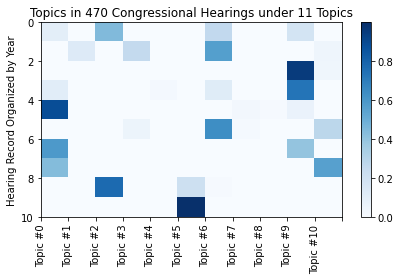

In [ ]:
# visualize distribution of topics among hearing 350-360
# this is 11-topic model
ldaDFV = ldaDF[350:360][['topic_%d' %x for x in range(lda.num_topics)]]
ldaDFVisN = ldaDF[350: 360][['title']]
ldaDFVis = ldaDFV.to_numpy()
ldaDFVisNames = ldaDFVisN.to_numpy()
topic_labels = ['Topic #{}'.format(k) for k in range(lda.num_topics)]

plt.pcolor(ldaDFV, norm=None, cmap='Blues')
# plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, range(0, 470))
plt.xticks(np.arange(ldaDFVis.shape[1]+0.5), topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()
plt.ylabel('Hearing Record Organized by Year')

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.title('Topics in 470 Congressional Hearings under 11 Topics')
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [ ]:
from importlib import reload
reload(plt)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


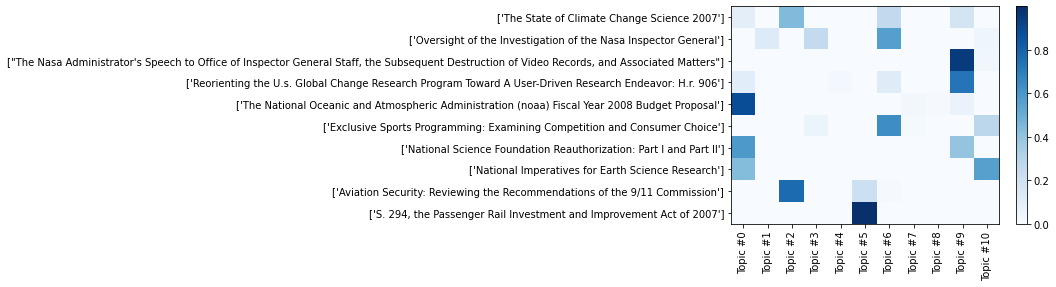

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [ ]:
# print out topics ; this is 7-topic model
def show_model_df(lda):
  topicsDict = {}
  for topicNum in range(lda.num_topics):
      topicWords = [w for w, p in lda.show_topic(topicNum)]
      topicsDict['Topic_{}'.format(topicNum)] = topicWords

  wordRanksDF = pandas.DataFrame(topicsDict)
  return wordRanksDF

In [ ]:
# systematically vary the number of topics
models = []
for n in range(6, 20):
  model = gensim.models.ldamodel.LdaModel(corpus=smm, 
                                               id2word=dictionary, 
                                               passes=3,
                                               num_topics=n, 
                                               alpha='auto',
                                               eta='auto')
  models.append(model)
  print('finished training model: topic_num=', n, model)

finished training model: topic_num= 6 LdaModel(num_terms=698, num_topics=6, decay=0.5, chunksize=2000)
finished training model: topic_num= 7 LdaModel(num_terms=698, num_topics=7, decay=0.5, chunksize=2000)
finished training model: topic_num= 8 LdaModel(num_terms=698, num_topics=8, decay=0.5, chunksize=2000)
finished training model: topic_num= 9 LdaModel(num_terms=698, num_topics=9, decay=0.5, chunksize=2000)
finished training model: topic_num= 10 LdaModel(num_terms=698, num_topics=10, decay=0.5, chunksize=2000)
finished training model: topic_num= 11 LdaModel(num_terms=698, num_topics=11, decay=0.5, chunksize=2000)
finished training model: topic_num= 12 LdaModel(num_terms=698, num_topics=12, decay=0.5, chunksize=2000)
finished training model: topic_num= 13 LdaModel(num_terms=698, num_topics=13, decay=0.5, chunksize=2000)
finished training model: topic_num= 14 LdaModel(num_terms=698, num_topics=14, decay=0.5, chunksize=2000)
finished training model: topic_num= 15 LdaModel(num_terms=698, 

In [ ]:
from gensim.models import CoherenceModel

coherence_lst = []
for model in models:
  cm = CoherenceModel(model=model, corpus=smm, coherence='u_mass')
  coherence_lst.append(cm.get_coherence()) 
coherence_lst

[-1.0556779258176376,
 -1.038271208694035,
 -1.2472327795033484,
 -1.1767030759866097,
 -1.1944699148882538,
 -1.0398695970583671,
 -1.3061180046479113,
 -1.366516900518719,
 -1.54459896994779,
 -1.6056294470413737,
 -1.2126184097442105,
 -1.2720626441428589,
 -1.1913162864000948,
 -1.2846990656059423]

In [ ]:
lda = models[1]

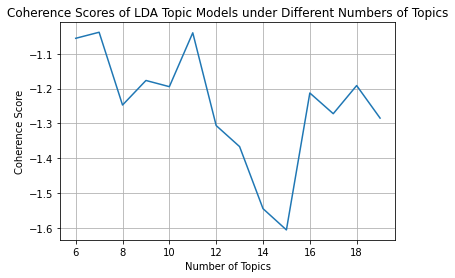

In [ ]:
n_lst = [n for n in range(6, 20)]
fig, ax = plt.subplots()
ax.plot(n_lst, coherence_lst)
ax.set(xlabel='Number of Topics', ylabel='Coherence Score',
       title='Coherence Scores of LDA Topic Models under Different Numbers of Topics')
ax.grid()
plt.show()

### Tuning parameters ###

A higher value for alpha means that a topic will be distributed more widely across the documents, whereas a lower value for alpha means that a topic will be distributed more narrowly across the documents. In my corpus, a higher alpha seems to makes sense (i.e. make top words in each topic more interpretable).

In [ ]:
# systematically vary alpha
models2 = []
for n in [0.1, 1, 10]:
  model = gensim.models.ldamodel.LdaModel(corpus=smm, 
                                               id2word=dictionary, 
                                               passes=3,
                                               num_topics=7, 
                                               alpha=n,
                                               eta='auto')
  models2.append(model)
  print('finished training model: alpha=', n, model)

finished training model: topic_num= 0.1 LdaModel(num_terms=698, num_topics=7, decay=0.5, chunksize=2000)
finished training model: topic_num= 1 LdaModel(num_terms=698, num_topics=7, decay=0.5, chunksize=2000)
finished training model: topic_num= 10 LdaModel(num_terms=698, num_topics=7, decay=0.5, chunksize=2000)


In [ ]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim import models
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

coherence_lst = []
for model in models2:
  cm = CoherenceModel(model=model, corpus=smm, coherence='u_mass')
  coherence_lst.append(cm.get_coherence()) 
coherence_lst

[-1.3819837024223998, -1.2400203942654182, -1.3204658497956583]

In [ ]:
df_lsts = []
for model in models2:
  df_lsts.append(show_model_df(model))
  
df_lsts[0] # alpha=0.1

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,nasa,faa,guard,science1,science1,tsa,science1
1,science1,aviation,nanotechnology,noaa,rail,science1,fcc
2,nuclear,hurricane,science1,ocean,student,jackie,broadband
3,exploration,airline,jackie,nist,carrier,coal,cable
4,shuttle,aircraft,child,sea,railroad,nsf,broadcast
5,flight,airport,vessel,coastal,teacher,dhs,radio
6,aeronautics,science1,scom1,fishery,engineer,passenger,television
7,phd,flight,drug,fish,jackie,co2,airline
8,engineer,jackie,solar,tsunami,universal,airport,jackie
9,iss,jpdo,fish,marine,driver,screen,jackf


In [ ]:
df_lsts[1] # alpha=1

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,science1,science1,broadband,faa,guard,nasa,hurricane
1,ocean,student,fcc,jackie,airline,science1,noaa
2,emission,nsf,cable,scom1,passenger,nanotechnology,phd
3,epa,engineer,wireless,gasoline,tsa,flight,ocean
4,carbon,railroad,provider,vessel,airport,nuclear,science1
5,noaa,teacher,jackie,fish,carrier,shuttle,forecast
6,coal,rail,child,aviation,jackie,exploration,nist
7,plant,solar,broadcast,jpdo,rail,aeronautics,coastal
8,co2,stem,television,fishery,flight,engineer,storm
9,sea,jackie,carrier,ftc,aviation,iss,jackie


In [ ]:
df_lsts[2] # alpha=10

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,airport,science1,nasa,rail,broadband,science1,guard
1,airline,nuclear,science1,science1,fcc,student,ocean
2,faa,emission,hurricane,phd,wireless,engineer,noaa
3,jackie,plant,exploration,railroad,jackie,nsf,science1
4,aviation,faa,flight,nanotechnology,carrier,teacher,vessel
5,tsa,carbon,shuttle,truck,universal,stem,fishery
6,child,waste,noaa,passenger,science1,nanotechnology,sea
7,cable,co2,aeronautics,jackie,epa,nasa,fish
8,carrier,coal,iss,coal,provider,scientist,marine
9,passenger,atsdr,engineer,solar,scom1,math,jackie


ETA controls prior distribution over word weights in each topic, i.e. how much each topic "likes" a word. Low ETA results in higher weight placed on the top words and lower weight placed on the bottom words for each topic - intuitively, topics are composed of few words; top words become 'irrelevant' more quickly. In my corpus, small ETA makes topics more interpretable.

In [ ]:
# systematically vary eta
models3 = []
for n in [0.1, 1, 10]:
  model = gensim.models.ldamodel.LdaModel(corpus=smm, 
                                               id2word=dictionary, 
                                               passes=3,
                                               num_topics=7, 
                                               alpha='auto',
                                               eta=n)
  models3.append(model)
  print('finished training model: eta=', n, model)

finished training model: eta= 0.1 LdaModel(num_terms=698, num_topics=7, decay=0.5, chunksize=2000)
finished training model: eta= 1 LdaModel(num_terms=698, num_topics=7, decay=0.5, chunksize=2000)
finished training model: eta= 10 LdaModel(num_terms=698, num_topics=7, decay=0.5, chunksize=2000)


In [ ]:
coherence_lst = []
for model in models3:
  cm = CoherenceModel(model=model, corpus=smm, coherence='u_mass')
  coherence_lst.append(cm.get_coherence()) 
coherence_lst

[-1.1849934688637904, -1.1932206215047094, -1.2999695843669397]

In [ ]:
df_lsts = []
for model in models3:
  df_lsts.append(show_model_df(model))
  
df_lsts[0] # eta=0.1

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,guard,broadband,hurricane,airline,science1,faa,nasa
1,science1,fcc,rail,airport,student,noaa,science1
2,tsunami,cable,jackie,science1,engineer,jackie,ocean
3,jackie,jackie,fishery,emission,nsf,rail,phd
4,truck,child,fish,faa,nuclear,fish,exploration
5,deepwater,nanotechnology,vessel,aviation,teacher,aquaculture,shuttle
6,hybrid,wireless,railroad,coal,scientist,scom1,flight
7,nist,television,noaa,carbon,stem,aviation,noaa
8,admiral,broadcast,scom1,passenger,epa,aircraft,aeronautics
9,asset,scom1,tsa,plant,nist,jackf,iss


In [ ]:
df_lsts[1] # eta=1

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,science1,guard,nasa,science1,faa,tsa,student
1,airline,science1,science1,noaa,broadband,jackie,science1
2,emission,rail,flight,ocean,carrier,airport,child
3,nuclear,railroad,exploration,nanotechnology,aviation,scom1,teacher
4,tsunami,phd,shuttle,epa,wireless,truck,engineer
5,carrier,nist,aeronautics,coastal,fcc,television,jackie
6,plant,coal,nsf,sea,cable,gasoline,fishery
7,carbon,jackie,engineer,marine,jackie,passenger,fish
8,greenhouse,dhs,hurricane,hurricane,airport,hybrid,ftc
9,jackie,plant,iss,fish,science1,screen,stem


In [ ]:
df_lsts[2] # eta=10

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,tsa,science1,rail,guard,broadband,science1,nasa
1,jackie,emission,phd,airline,fcc,nanotechnology,science1
2,passenger,carbon,ftc,fish,wireless,nuclear,flight
3,driver,coal,hurricane,ocean,child,epa,faa
4,airport,plant,jackf,jackie,cable,engineer,exploration
5,dhs,co2,railroad,noaa,science1,solar,shuttle
6,border,ocean,jackie,faa,provider,noaa,aeronautics
7,screen,greenhouse,0ct,airport,student,nasa,engineer
8,carrier,jackie,passenger,vessel,jackie,waste,nist
9,truck,scom1,scom1,fishery,universal,nsf,hurricane


In [ ]:
FeatureDF = ldaDF[['topic_0', 'topic_1', 'topic_2','topic_3','topic_4','topic_5', 'topic_6']]


In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, 
                                                               max_features=1010, 
                                                               min_df=1, 
                                                               stop_words='english',
                                                               norm='l2')

In [ ]:
# fit a new k-mean clustering with topics as additional feature; have not managed to make it work
TFVects3 = TFVectorizer.fit_transform(DF0510['raw_text'])
TFVects3 = np.append(TFVects3 , FeatureDF.to_numpy())

NameError: ignored

In [ ]:
KM3 = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
KM3.fit(TFVects3)

ValueError: ignored

In [ ]:
TFVects3

array([<470x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 145812 stored elements in Compressed Sparse Row format>,
       0.0, 0.0, ..., 0.0, 0.0, 0.0], dtype=object)

In [ ]:
FeatureDF

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
324,0.000000,0.000000,0.358744,0.0,0.640481,0.0,0.000000
262,0.000000,0.000000,0.026157,0.0,0.579163,0.0,0.387950
263,0.999779,0.000000,0.000000,0.0,0.000000,0.0,0.000000
117,0.000000,0.000000,0.997017,0.0,0.000000,0.0,0.000000
112,0.000000,0.000000,0.999689,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
344,0.472346,0.523977,0.000000,0.0,0.000000,0.0,0.000000
350,0.933412,0.026517,0.039374,0.0,0.000000,0.0,0.000000
120,0.855716,0.000000,0.143984,0.0,0.000000,0.0,0.000000
90,0.000000,0.113858,0.000000,0.0,0.356717,0.0,0.529022


## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does. `lucem_illud.loadDavies` can be found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [ ]:
corpora_address = "/root/data"

In [ ]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

FileNotFoundError: ignored

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/sources_movies.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[:10]

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, _, _, _, year, language , _, _, show = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][9]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav (the author of most of this class's code) wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts, and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [ ]:
DF0510

,index,title,raw_text,tokenized_text,normalized_tokens,year
0,CHRG-109hhrg20007,The Future of Aeronautics at Nasa,THE FUTURE OF\n\nAERONAUTICS AT NASA\n\nHE...,"[THE, FUTURE, OF, AERONAUTICS, AT, NASA, HEARI...","[future, aeronautics, nasa, hear, subcommittee...",2005
1,CHRG-110hhrg34012,National Science Foundation Reauthorization: P...,NATIONAL SCIENCE FOUNDATION\n\nREAUTHORIZATI...,"[NATIONAL, SCIENCE, FOUNDATION, REAUTHORIZATIO...","[national, science, foundation, reauthorizatio...",2007
2,CHRG-110hhrg40941,Toxic Trailers: Have the Centers for Disease C...,TOXIC TRAILERS: HAVE THE CENTERS\nFOR DIS...,"[TOXIC, TRAILERS, HAVE, THE, CENTERS, FOR, DIS...","[toxic, trailer, center, disease, control, fai...",2008
3,CHRG-110hhrg40940,The Department of Energy Fiscal Year 2009 Rese...,THE DEPARTMENT OF ENERGY\n\nFISCAL YEAR 2...,"[THE, DEPARTMENT, OF, ENERGY, FISCAL, YEAR, 20...","[department, energy, fiscal, year, research, d...",2008
4,CHRG-110shrg41101,Oversight of the Investigation of the Nasa Ins...,S. HRG. 110–434 \nSERIAL 110–37 \n\nOVERSIGH...,"[S., HRG, 110–434, SERIAL, 110–37, OVERSIGHT, ...","[s., hrg, 110–434, serial, 110–37, oversight, ...",2007
...,...,...,...,...,...,...
465,CHRG-110hhrg41800,Aviation Security Research and Development at ...,AVIATION SECURITY RESEARCH AND\n\nDEVELOPME...,"[AVIATION, SECURITY, RESEARCH, AND, DEVELOPMEN...","[aviation, security, research, development, de...",2008
466,CHRG-109hhrg20735,Priorities in the Department of Energy Budget ...,PRIORITIES IN THE DEPARTMENT OF ENERGY\n\...,"[PRIORITIES, IN, THE, DEPARTMENT, OF, ENERGY, ...","[priority, department, energy, budget, fiscal,...",2005
467,CHRG-109hhrg24525,Ongoing Problems and Future Plans for Noaa's W...,ONGOING PROBLEMS AND FUTURE PLANS\n\nFOR ...,"[ONGOING, PROBLEMS, AND, FUTURE, PLANS, FOR, N...","[ongoing, problem, future, plan, noaa, weather...",2005
468,CHRG-110shrg73896,Rail Safety Reauthorization,RAIL SAFETY REAUTHORIZATION \n\nS. HRG. 11...,"[RAIL, SAFETY, REAUTHORIZATION, S., HRG, 110–1...","[rail, safety, reauthorization, s., hrg, 110–1...",2007


In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [ ]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

For future research, you can also consider the Structural Topic Model (STM), which can integrate any covariates (e.g., time, author, document length) into your topic model. Unfortunately there is not yet an implementation of this in Python, but there is a wonderful [R package](https://www.structuraltopicmodel.com/) authored by Molly Roberts, Brandon Stewart, and Dustin Tingley.

Here are plate diagrams of LDA and STM, which may help you visualize the way STM adds covariates to the "left" and "right" of the standard LDA model.

<img src="img/lda_stm_plate_diagrams.jpg" alt="img/lda_stm_plate_diagrams.jpg"/>



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

I trained a subset of my corpus - all hearings under topic 1 of my topic model, which is supposedly about communictaion technology, on dynamic topic model from 2005 to 2008. Because the time span is short, most policy discourse in this area turns out to be stable; however, IP & VoiceIP emerges as new top words during 2006 to 2007, suggesting new technology entering policy discussion.

In [ ]:
# Train a topic model to subselect hearings under one topic as inputs for dynamic topic model 
dictionary = gensim.corpora.Dictionary(DF0510['reduced_tokens'])

In [ ]:
corpus = [dictionary.doc2bow(text) for text in DF0510['reduced_tokens']]

In [ ]:
gensim.corpora.MmCorpus.serialize('hearing.mm', corpus)
senmm = gensim.corpora.MmCorpus('hearing.mm')

In [ ]:
lda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=7, alpha='auto', eta='auto')
ldaDF = pandas.DataFrame({
        'index' : DF0510['index'],
        'year' : DF0510['year'],
        'topics' : [lda[dictionary.doc2bow(l)] for l in DF0510['reduced_tokens']]
    })
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [ ]:
# select all hearings under topic 1; from 4 years
topic1_lst = ldaDF.loc[ldaDF['topic_1'] >= 0.5]['index']
newdf = DF0510.iloc[topic1_lst, :]loc[DF0510['index'].isin(topic1_lst) & DF0510['year'].isin(['2005', '2006', '2007', '2008'])]

In [ ]:
newdf.sort_values(by= 'year')

In [ ]:
# prepare corpus for dynamic topic model
dictionary = gensim.corpora.Dictionary(newdf['reduced_tokens'])

In [ ]:
corpus = [dictionary.doc2bow(text) for text in newdf['reduced_tokens']]

In [ ]:
gensim.corpora.MmCorpus.serialize('hearing.mm', corpus)
senmm = gensim.corpora.MmCorpus('hearing.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
docs_per_time_slice = [5, 6, 9, 6]

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=3, chain_variance=0.5)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldaseqmodel.py:290: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [ ]:
import dtm # a custom module for printing models
dtm.print_dtm(ldaseq, n_topics=3, n_time_slices=4)

##### Topic 0, Time Slice 0 #####
['faa', 'airport', 'aviation', 'airline', 'jackie', 'aircraft', 'flight', 'passenger', 'runway', 'airspace']
##### Topic 0, Time Slice 1 #####
['airport', 'airline', 'flight', 'faa', 'passenger', 'aircraft', 'airspace', 'dot', 'aviation', 'congestion']
##### Topic 0, Time Slice 2 #####
['airport', 'aviation', 'faa', 'aircraft', 'jet', 'flight', 'passenger', 'airline', 'airspace', 'fly']
##### Topic 0, Time Slice 3 #####
['airline', 'passenger', 'flight', 'faa', 'aviation', 'jackie', 'carrier', 'fly', 'airport', 'aircraft']


##### Topic 1, Time Slice 0 #####
['aviation', 'airport', 'aircraft', 'flight', 'jackf', 'tsa', 'faa', '0ct', 'fly', 'airspace']
##### Topic 1, Time Slice 1 #####
['faa', 'repair', 'aircraft', 'aviation', 'inspector', 'carrier', 'airline', 'scom1', 'jackie', 'inspection']
##### Topic 1, Time Slice 2 #####
['faa', 'aviation', 'inspector', 'airline', 'carrier', 'runway', 'jackf', 'repair', 'aircraft', 'airport']
##### Topic 1, Time S

In [ ]:
pip install pyldavis
from ipywidgets import interact
import pyLDAvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
topic_weights = pandas.DataFrame([ldaseq.doc_topics(j) for j in range(len(corpus))],
                             columns=['topic0', 'topic1', 'topic2'])

In [ ]:
# map each hearing to topics predicted by the model
dtmDF = pandas.DataFrame({
        'title' : newdf['title'],
        'year' : newdf['year'],
        'topics' : [ldaseq[dictionary.doc2bow(l)] for l in newdf['reduced_tokens']]
    })
dtmDF['topic0'] = topic_weights['topic0'].values.tolist()
dtmDF['topic1'] = topic_weights['topic1'].values.tolist()
dtmDF['topic2'] = topic_weights['topic2'].values.tolist()

In [ ]:
terms = {}
for i, year in enumerate(['2005', '2006', '2007', '2008']):
  terms[year] = []
  for n in range(3):
    terms[year].append(ldaseq.print_topic(n, time=i, top_terms=30))

In [ ]:
for year in ['2005', '2006', '2007', '2008']:
  print(year, '\n')
  topic_lst = terms[year]
  for i, topic in enumerate(topic_lst):
    print('Topic', i, topic, '\n')

In [ ]:
dtmDF['topics'][[5]]

5    [0.222262473914636, 0.7777311486563607, 6.3774...
Name: topics, dtype: object

In [ ]:
dtmDFV = topic_weights
dtmDFVisN = dtmDF[:][['title']]
dtmDFVis = dtmDFV.to_numpy()
dtmDFVisNames = dtmDFVisN.to_numpy()
dtmDFV

,topic0,topic1,topic2
0,0.255549,0.744444,0.000006
1,0.000003,0.999993,0.000003
2,0.935139,0.000004,0.064857
3,0.000003,0.000003,0.999994
4,0.985604,0.014393,0.000003
5,0.013711,0.003457,0.982832
6,0.005672,0.618129,0.376199
7,0.000003,0.288704,0.711293
8,0.002248,0.997749,0.000003
9,0.999993,0.000004,0.000004


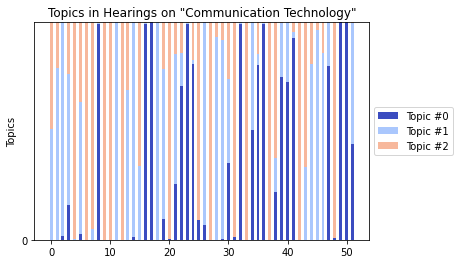

In [ ]:
N = 52
ind = np.arange(N)
K = 3  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for i, k in enumerate(['topic0', 'topic1', 'topic2']):
    color = plt.cm.coolwarm(i/K, 1)
    if k == 'topic0':
        p = plt.bar(ind, dtmDFV[k], width, color=color)
    else:
        p = plt.bar(ind, dtmDFV[k], width, bottom=height_cumulative, color=color)
    height_cumulative += dtmDFV[k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Hearings on "Communication Technology"')
# plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

In [ ]:
dtmDF

In [ ]:
pyLDAvis.enable_notebook()

# Create pyLDAvis visualization for each year:
vis = {}
dates = pandas.Series(['2005', '2006', '2007', '2008'])
for i in range(4):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                            doc_topic_dists=doc_topic,
                                            doc_lengths=doc_lengths,
                                            vocab=vocab,
                                            term_frequency=term_frequency)

# Make an interactive plot so we can cycle through topics by year:
@interact(Year=dates)
def f(Year):
    return vis[Year]